In [ ]:
! wget http://qwone.com/~jason/20Newsgroups/20news-bydate-matlab.tgz
! tar xzvf 20news-bydate-matlab.tgz
! cp /content/20news-bydate/matlab/train.data /content/
! rm -rf 20news-bydate

--2021-04-23 21:13:53--  http://qwone.com/~jason/20Newsgroups/20news-bydate-matlab.tgz
Resolving qwone.com (qwone.com)... 173.48.209.137
Connecting to qwone.com (qwone.com)|173.48.209.137|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7575962 (7.2M) [application/x-gzip]
Saving to: ‘20news-bydate-matlab.tgz’

20news-bydate-matla 100%[===================>]   7.22M  2.21MB/s    in 3.3s    

2021-04-23 21:13:56 (2.21 MB/s) - ‘20news-bydate-matlab.tgz’ saved [7575962/7575962]

20news-bydate/matlab/
20news-bydate/matlab/train.data
20news-bydate/matlab/train.label
20news-bydate/matlab/train.map
20news-bydate/matlab/test.data
20news-bydate/matlab/test.label
20news-bydate/matlab/test.map


In [ ]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import statistics

file1 = open('train.data', 'r')
Lines = file1.readlines()
original_freq = defaultdict(int)

# count original frequency and test set

for line in Lines:
    docidx, wordidx, countidx = map(int, line.split())
    original_freq[wordidx] += countidx

arr = []
for j in original_freq:
    arr.append((j, original_freq[j]))
arr.sort(key= lambda x: x[1], reverse=True)

final_arr = []
taken = set()
j = 0
while(j<100):
    x = random.randint(0, 999)
    if x in taken:
        continue
    else:
        taken.add(x)
        final_arr.append(arr[x])
        j+=1

k_values = [100, 200, 500, 1000, 2000]
w = 5

Count Sketch

In [ ]:
def CS_sketch(k, w, p, params):
  d = k//w
  sketch = []
  for j in range(w):
      x = [0]*d
      sketch.append(x)

  for line in Lines:
      docidx, wordidx, countidx = map(int, line.split())
      for j in params:
          a,b = params[j][0]
          c,v = params[j][1]
          x = ((a*wordidx + b)%p)%d
          temp = ((c*wordidx + v)%p)%2
          if (temp==0):
              g = -1
          else:
              g = 1
          sketch[j][x] += g*countidx

  err = 0
  for j in range(100):
      word = final_arr[j][0]
      fx = final_arr[j][1]
      ans = []
      for j in params:
          a,b = params[j][0]
          c,v = params[j][1]
          x = ((a*word + b)%p)%d
          temp = ((c*word + v)%p)%2
          if (temp==0):
              g = -1
          else:
              g = 1
          ans.append(g*sketch[j][x])
      final = int(statistics.median(ans))
      err += abs(fx-final)/fx
  err = err/100
  return err

p = 2**31 - 1
cs_errors = []
params = {}
all_params = {}
j = 0
w = 5
while j<w:
    a = random.randint(1, p)
    b = random.randint(1, p)
    c = random.randint(1, p)
    v = random.randint(1, p)
    if a in all_params and b in all_params:
      continue
    elif c in all_params and v in all_params:
      continue
    else:
      all_params[a] = 0
      all_params[b] = 0
      all_params[c] = 0
      all_params[v] = 0
      params[j] = [(a,b), (c,v)]
      j+=1
# print(params)
for k in k_values:
  error = CS_sketch(k, w, p, params)
  cs_errors.append(error)
print(cs_errors)

[25.806105414775, 18.629308634904966, 5.6126023142098145, 2.9853180437648206, 1.1702040320576197]


Count Min Sketch

In [ ]:
def CM_sketch(k,w,p):
    d = k//w
    params = {}
    all_params = {}
    original_freq = defaultdict(int)

    for j in range(w):
        a = random.randint(1, p)
        b = random.randint(1, p)
        all_params[a] = 0
        all_params[b] = 0
        params[j] = (a,b)

    sketch = []
    for j in range(w):
        x = [0]*d
        sketch.append(x)

    for line in Lines:
        docidx, wordidx, countidx = map(int, line.split())
        for j in params:
            a,b = params[j]
            x = ((a*wordidx + b)%p)%d
            sketch[j][x] += countidx

    # print(sketch)
    arr = []
    for j in original_freq:
        arr.append((j, original_freq[j]))
    arr.sort(key= lambda x: x[1], reverse=True)

    err = 0
    for j in range(100):
        word = final_arr[j][0]
        fx = final_arr[j][1]
        ans = 2**31
        for j in params:
            a,b = params[j]
            x = ((a*word + b)%p)%d
            ans = min(sketch[j][x], ans)
        err += abs(fx-ans)/fx
    err = err/100
    return err

p = 2**31 - 1
cm_errors = []
for k in k_values:
  error = CM_sketch(k, w, p)
  cm_errors.append(error)
print(cm_errors)

[173.1995762464932, 74.74012804778238, 26.106393458747178, 12.129432805837862, 4.9627088384172575]


Misra-Gries Algorithm

In [ ]:
original_freq = defaultdict(int)
from collections import Counter

def misra_gries(k):
    counters = Counter()
    for line in Lines:
        docidx, wordidx, countidx = map(int, line.split())
        original_freq[wordidx] += countidx
        if wordidx in counters or len(counters) < k:
            counters[wordidx] += 1
        else:
            for key in list(counters.keys()):
                counters[key] -= 1
                if counters[key] == 0:
                    del counters[key]
    return counters

In [ ]:
mg_errors = []
for k in k_values:
    top_words = misra_gries(k)
    err = 0
    for j in range(100):
      word = final_arr[j][0]
      fx = final_arr[j][1]
      if word in top_words:
        err += abs(fx - top_words[word])/fx
      else:
        err += abs(fx)/fx
    err = err/100
    mg_errors.append(err/100)

print(mg_errors)

[0.01, 0.009999667935525949, 0.009974462102357706, 0.009784966886983219, 0.00901999757181991]


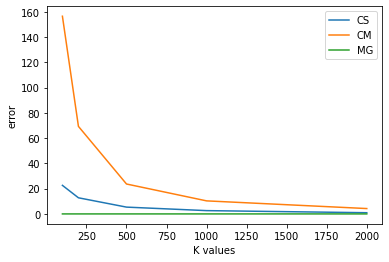

In [ ]:
import matplotlib.pyplot as plt
plt.plot(k_values,cs_errors, label="CS")
plt.plot(k_values,cm_errors, label="CM")
plt.plot(k_values,mg_errors, label="MG")
plt.xlabel("K values")
plt.ylabel("error")
plt.legend()
plt.show()

Count Min sketch Min d value

In [ ]:
n = 120000
while(error<1):
  error = CM_sketch(n, w, p)*100
  n = n-1000
print("Minimum d for CM sketch is -->", n+1000)

1.1408162712016898
106000


Count Sketch Min d value

In [ ]:
p = 2**31 - 1
cs_errors = []
params = {}
all_params = {}
j = 0
w = 5
while j<w:
    a = random.randint(1, p)
    b = random.randint(1, p)
    c = random.randint(1, p)
    v = random.randint(1, p)
    if a in all_params and b in all_params:
      continue
    elif c in all_params and v in all_params:
      continue
    else:
      all_params[a] = 0
      all_params[b] = 0
      all_params[c] = 0
      all_params[v] = 0
      params[j] = [(a,b), (c,v)]
      j+=1
n = 240000
error = 0
while(error<1):
  error = CS_sketch(n, w, p, params)*100
  print(error)
  n = n-1000
print("Minimum d for CS sketch is -->", n+1000)

0.3350023523712924
0.1814762161102318
0.3129080512091402
0.5243396357892253
0.07557078654327473
0.3742813026419678
0.2504763654585799
0.17801236700411152
0.13707254111151942
0.08506260602087946
0.08370677289007251
0.76823412541546
0.8494652126868618
0.3560384493994261
0.6702921822644737
0.17554178295275893
0.38194187061203183
0.2082937099316481
0.2301835436652239
0.8002384684908277
0.2888171512175761
0.24218302070337228
0.2626513043113814
0.22604181582938718
0.7525224900613425
0.33249890877916977
0.23161487786726065
0.22125242057594416
0.2076421159607899
0.2516271940587898
0.34218659457651784
0.14102279978723226
1.0345674350505163
Minimum d for CS sketch is --> 208000


Misra Gries Min d value = 100 because we already saw above that at k = 100 the error comes out to be 0.01 or 1% and hence the d = 100/5 = 20